In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi


# Define the exact solution
#def exact_solution(x, t):
 #   return torch.sin(x)*torch.cos(4*pi*t)


def initial_condition(x):
    return torch.sin(x/pi)

def initial_condition_time(x):
    return 0*np.pi**2*torch.sin(np.pi*x)

# assigning number of points
initial_pts = 200
left_boundary_pts = 200
right_boundary_pts = 200
residual_pts = 1000

# Type of optimizer (ADAM or LBFGS)
opt_type = "ADAM"
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi**2*torch.rand((initial_pts,1)) # initial pts
t_init =  0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition(init[:,0]).reshape(-1, 1)
u_init_t = initial_condition_time(init[:,0]).reshape(-1, 1) #new



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = (pi**2/200)*torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = 0*xb_left
u_b_l_xx = 0*xb_left #new



xb_right = pi**2*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = (pi**2/200)*torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = 0*xb_right
u_b_r_xx = 0*xb_right #new


x_interior = pi**2*torch.rand((residual_pts, 1))
t_interior = (pi**2/200)*torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, u_init, u_init_t, b_left, b_right), batch_size=200, shuffle=False)


class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=20)

def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")
  
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, u_initial, u_initial_t, bd_left, bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                
                initial.requires_grad = True
                 # for initial
                u_initial_pred_ = model(initial)
                inputs1 = torch.ones(initial_pts, 1 )
                grad_u_initial = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inputs1, create_graph=True)[0]
                u_initial_pred_t_ =  grad_u_initial[:, 1]
                
                
                
                bd_left.requires_grad = True
                bd_right.requires_grad = True
                u_bd_left_pred_ = model(bd_left)
                u_bd_right_pred_ = model(bd_right)
                inputs2 = torch.ones(left_boundary_pts, 1)
                inputs3 = torch.ones(right_boundary_pts, 1)
                grad_u_b_l = torch.autograd.grad(u_bd_left_pred_, bd_left, grad_outputs=inputs2, create_graph=True)[0]
                grad_u_b_r = torch.autograd.grad(u_bd_right_pred_, bd_right, grad_outputs=inputs3, create_graph=True)[0]
                u_b_l_x = grad_u_b_l[:, 0]
                u_b_r_x = grad_u_b_r[:, 0]
                u_b_l_xx = torch.autograd.grad(u_b_l_x, bd_left, grad_outputs=torch.ones(bd_left.shape[0]), create_graph=True)[0]
                u_bd_left_pred_xx_ = u_b_l_xx[:, 0]
                
                u_b_r_xx = torch.autograd.grad(u_b_r_x, bd_right, grad_outputs=torch.ones(bd_right.shape[0]), create_graph=True)[0]
                u_bd_right_pred_xx_ = u_b_r_xx[:, 0]
                
                
                
                
                
                
               
                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1 )
              
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0]
                u_t =  grad_u_hat[:, 1]
                
                grad_grad_u_t = torch.autograd.grad(u_t, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_tt = grad_grad_u_t[:, 1]
                
                grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xx = grad_grad_u_x[:, 0]
                
                grad_grad_u_xx = torch.autograd.grad(u_xx, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xxx = grad_grad_u_xx[:, 0]
                
                grad_grad_u_xxx = torch.autograd.grad(u_xxx, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xxxx = grad_grad_u_xxx[:, 0]
                
                k1 = -pi**3*(1-16*pi**2)*torch.sin(interior[:, 0]/pi)*torch.cos(4*interior[:, 1]/pi)
                
                
                # Item 1. below
                #loss = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, ))**p) + torch.mean((u_initial_pred_t_.reshape(-1, ) - u_initial_t.reshape(-1, ))**p) + torch.mean((100*u_tt.reshape(-1, ) + 4*10**(6)*u_xxxx.reshape(-1, )-(1/pi**3)*4*10**(6)*(1 -16*pi**2)*torch.sin(interior[:, 0]/pi)*torch.cos(800*interior[:, 1]/pi))**p)+torch.mean((u_bd_left_pred_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,))**p)+torch.mean((u_bd_left_pred_xx_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_xx_.reshape(-1,))**p)
                loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_initial_pred_t_.reshape(-1, ) - u_initial_t.reshape(-1, )))) + torch.max(torch.abs((100*u_tt.reshape(-1, ) + 4*10**(6)*u_xxxx.reshape(-1, )-(1/pi**3)*4*10**(6)*(1 -16*pi**2)*torch.sin(interior[:, 0]/pi)*torch.cos(800*interior[:, 1]/pi)))) + torch.max(torch.abs(u_bd_left_pred_.reshape(-1,))) + torch.max(torch.abs(u_bd_right_pred_.reshape(-1,))) + torch.max(torch.abs( u_bd_left_pred_xx_.reshape(-1,))) + torch.max(torch.abs( u_bd_right_pred_xx_.reshape(-1,)))
                # Item 2. below
               
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history
n_epochs = 15000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )





################################  0  ################################
Loss:  44464488448.0
################################  1  ################################
Loss:  31235026944.0
################################  2  ################################
Loss:  20547602432.0
################################  3  ################################
Loss:  13934161920.0
################################  4  ################################
Loss:  8634022912.0
################################  5  ################################
Loss:  6681209344.0
################################  6  ################################
Loss:  6210238976.0
################################  7  ################################
Loss:  6279016960.0
################################  8  ################################
Loss:  6058330624.0
################################  9  ################################
Loss:  5680944128.0
################################  10  ################################
Loss:  5543369216.0
#####

Loss:  173545344.0
################################  91  ################################
Loss:  198777536.0
################################  92  ################################
Loss:  154737120.0
################################  93  ################################
Loss:  109702288.0
################################  94  ################################
Loss:  199428608.0
################################  95  ################################
Loss:  201304576.0
################################  96  ################################
Loss:  174555584.0
################################  97  ################################
Loss:  135051904.0
################################  98  ################################
Loss:  167693376.0
################################  99  ################################
Loss:  139281632.0
################################  100  ################################
Loss:  91360576.0
################################  101  ################################
Loss:  14

Loss:  81050624.0
################################  183  ################################
Loss:  48878972.0
################################  184  ################################
Loss:  67183976.0
################################  185  ################################
Loss:  47144756.0
################################  186  ################################
Loss:  71988368.0
################################  187  ################################
Loss:  44917496.0
################################  188  ################################
Loss:  111067488.0
################################  189  ################################
Loss:  128648176.0
################################  190  ################################
Loss:  96908168.0
################################  191  ################################
Loss:  48279068.0
################################  192  ################################
Loss:  71565888.0
################################  193  ################################
Loss:  5

Loss:  39861748.0
################################  278  ################################
Loss:  54156928.0
################################  279  ################################
Loss:  63292672.0
################################  280  ################################
Loss:  41081588.0
################################  281  ################################
Loss:  54296636.0
################################  282  ################################
Loss:  69863320.0
################################  283  ################################
Loss:  49221468.0
################################  284  ################################
Loss:  47375952.0
################################  285  ################################
Loss:  84909792.0
################################  286  ################################
Loss:  89555656.0
################################  287  ################################
Loss:  38943864.0
################################  288  ################################
Loss:  479

Loss:  32702428.0
################################  374  ################################
Loss:  52820500.0
################################  375  ################################
Loss:  42685764.0
################################  376  ################################
Loss:  37784284.0
################################  377  ################################
Loss:  69151560.0
################################  378  ################################
Loss:  61745284.0
################################  379  ################################
Loss:  32850106.0
################################  380  ################################
Loss:  63643428.0
################################  381  ################################
Loss:  66887236.0
################################  382  ################################
Loss:  46590548.0
################################  383  ################################
Loss:  41738916.0
################################  384  ################################
Loss:  760

Loss:  39258296.0
################################  465  ################################
Loss:  40663056.0
################################  466  ################################
Loss:  70366648.0
################################  467  ################################
Loss:  59406476.0
################################  468  ################################
Loss:  31010190.0
################################  469  ################################
Loss:  68350112.0
################################  470  ################################
Loss:  88185808.0
################################  471  ################################
Loss:  70871544.0
################################  472  ################################
Loss:  38113036.0
################################  473  ################################
Loss:  54432524.0
################################  474  ################################
Loss:  65009040.0
################################  475  ################################
Loss:  571

Loss:  23650510.0
################################  558  ################################
Loss:  25067038.0
################################  559  ################################
Loss:  24767850.0
################################  560  ################################
Loss:  26852164.0
################################  561  ################################
Loss:  32273650.0
################################  562  ################################
Loss:  23381768.0
################################  563  ################################
Loss:  22837888.0
################################  564  ################################
Loss:  27979614.0
################################  565  ################################
Loss:  22432818.0
################################  566  ################################
Loss:  22404940.0
################################  567  ################################
Loss:  29787432.0
################################  568  ################################
Loss:  223

Loss:  46565828.0
################################  656  ################################
Loss:  31484426.0
################################  657  ################################
Loss:  23369386.0
################################  658  ################################
Loss:  29428498.0
################################  659  ################################
Loss:  20753732.0
################################  660  ################################
Loss:  22403904.0
################################  661  ################################
Loss:  20358384.0
################################  662  ################################
Loss:  20248054.0
################################  663  ################################
Loss:  24636684.0
################################  664  ################################
Loss:  20245710.0
################################  665  ################################
Loss:  23756780.0
################################  666  ################################
Loss:  202

Loss:  20252958.0
################################  749  ################################
Loss:  32295772.0
################################  750  ################################
Loss:  23939048.0
################################  751  ################################
Loss:  42885648.0
################################  752  ################################
Loss:  38087908.0
################################  753  ################################
Loss:  20399180.0
################################  754  ################################
Loss:  39788328.0
################################  755  ################################
Loss:  45517976.0
################################  756  ################################
Loss:  31172218.0
################################  757  ################################
Loss:  20253860.0
################################  758  ################################
Loss:  42425592.0
################################  759  ################################
Loss:  407

Loss:  21684002.0
################################  841  ################################
Loss:  24328292.0
################################  842  ################################
Loss:  20260028.0
################################  843  ################################
Loss:  27241724.0
################################  844  ################################
Loss:  20639822.0
################################  845  ################################
Loss:  20262074.0
################################  846  ################################
Loss:  38301816.0
################################  847  ################################
Loss:  40728840.0
################################  848  ################################
Loss:  25139756.0
################################  849  ################################
Loss:  21735138.0
################################  850  ################################
Loss:  38507764.0
################################  851  ################################
Loss:  370

Loss:  31010024.0
################################  938  ################################
Loss:  22725778.0
################################  939  ################################
Loss:  20261048.0
################################  940  ################################
Loss:  29352264.0
################################  941  ################################
Loss:  21811224.0
################################  942  ################################
Loss:  20262624.0
################################  943  ################################
Loss:  38923968.0
################################  944  ################################
Loss:  35441008.0
################################  945  ################################
Loss:  20265090.0
################################  946  ################################
Loss:  20265732.0
################################  947  ################################
Loss:  39465644.0
################################  948  ################################
Loss:  352

Loss:  30048440.0
################################  1035  ################################
Loss:  29515438.0
################################  1036  ################################
Loss:  20259632.0
################################  1037  ################################
Loss:  20260512.0
################################  1038  ################################
Loss:  33297682.0
################################  1039  ################################
Loss:  26927816.0
################################  1040  ################################
Loss:  20260356.0
################################  1041  ################################
Loss:  27742426.0
################################  1042  ################################
Loss:  28105474.0
################################  1043  ################################
Loss:  20260938.0
################################  1044  ################################
Loss:  20261984.0
################################  1045  ################################

Loss:  20265074.0
################################  1132  ################################
Loss:  20264654.0
################################  1133  ################################
Loss:  20264254.0
################################  1134  ################################
Loss:  20263874.0
################################  1135  ################################
Loss:  20263508.0
################################  1136  ################################
Loss:  20263158.0
################################  1137  ################################
Loss:  20262820.0
################################  1138  ################################
Loss:  20262498.0
################################  1139  ################################
Loss:  20262186.0
################################  1140  ################################
Loss:  20261886.0
################################  1141  ################################
Loss:  20261594.0
################################  1142  ################################

Loss:  20243192.0
################################  1225  ################################
Loss:  20242974.0
################################  1226  ################################
Loss:  20242754.0
################################  1227  ################################
Loss:  20242536.0
################################  1228  ################################
Loss:  20242316.0
################################  1229  ################################
Loss:  20242098.0
################################  1230  ################################
Loss:  20241878.0
################################  1231  ################################
Loss:  20241658.0
################################  1232  ################################
Loss:  20241438.0
################################  1233  ################################
Loss:  20241218.0
################################  1234  ################################
Loss:  20240998.0
################################  1235  ################################

Loss:  20222692.0
################################  1316  ################################
Loss:  20222460.0
################################  1317  ################################
Loss:  20222228.0
################################  1318  ################################
Loss:  20221996.0
################################  1319  ################################
Loss:  20221766.0
################################  1320  ################################
Loss:  20221534.0
################################  1321  ################################
Loss:  20221300.0
################################  1322  ################################
Loss:  20221312.0
################################  1323  ################################
Loss:  20221474.0
################################  1324  ################################
Loss:  20221604.0
################################  1325  ################################
Loss:  20221702.0
################################  1326  ################################

Loss:  20221142.0
################################  1409  ################################
Loss:  20221150.0
################################  1410  ################################
Loss:  20221184.0
################################  1411  ################################
Loss:  20221188.0
################################  1412  ################################
Loss:  20221166.0
################################  1413  ################################
Loss:  20221124.0
################################  1414  ################################
Loss:  20221156.0
################################  1415  ################################
Loss:  20221184.0
################################  1416  ################################
Loss:  20221192.0
################################  1417  ################################
Loss:  20221180.0
################################  1418  ################################
Loss:  20221152.0
################################  1419  ################################

Loss:  20221056.0
################################  1500  ################################
Loss:  20221058.0
################################  1501  ################################
Loss:  20221036.0
################################  1502  ################################
Loss:  20221050.0
################################  1503  ################################
Loss:  20221066.0
################################  1504  ################################
Loss:  20221060.0
################################  1505  ################################
Loss:  20221034.0
################################  1506  ################################
Loss:  20221046.0
################################  1507  ################################
Loss:  20221062.0
################################  1508  ################################
Loss:  20221050.0
################################  1509  ################################
Loss:  20221014.0
################################  1510  ################################

Loss:  20220936.0
################################  1591  ################################
Loss:  20220940.0
################################  1592  ################################
Loss:  20220934.0
################################  1593  ################################
Loss:  20220942.0
################################  1594  ################################
Loss:  20220946.0
################################  1595  ################################
Loss:  20220928.0
################################  1596  ################################
Loss:  20220952.0
################################  1597  ################################
Loss:  20220962.0
################################  1598  ################################
Loss:  20220942.0
################################  1599  ################################
Loss:  20220934.0
################################  1600  ################################
Loss:  20220948.0
################################  1601  ################################

Loss:  20220848.0
################################  1686  ################################
Loss:  20220850.0
################################  1687  ################################
Loss:  20220824.0
################################  1688  ################################
Loss:  20220850.0
################################  1689  ################################
Loss:  20220868.0
################################  1690  ################################
Loss:  20220860.0
################################  1691  ################################
Loss:  20220832.0
################################  1692  ################################
Loss:  20220836.0
################################  1693  ################################
Loss:  20220856.0
################################  1694  ################################
Loss:  20220842.0
################################  1695  ################################
Loss:  20220810.0
################################  1696  ################################

Loss:  20220734.0
################################  1781  ################################
Loss:  20220708.0
################################  1782  ################################
Loss:  20220716.0
################################  1783  ################################
Loss:  20220700.0
################################  1784  ################################
Loss:  20220734.0
################################  1785  ################################
Loss:  20220740.0
################################  1786  ################################
Loss:  20220712.0
################################  1787  ################################
Loss:  20220722.0
################################  1788  ################################
Loss:  20220740.0
################################  1789  ################################
Loss:  20220730.0
################################  1790  ################################
Loss:  20220698.0
################################  1791  ################################

Loss:  20220612.0
################################  1874  ################################
Loss:  20220630.0
################################  1875  ################################
Loss:  20220622.0
################################  1876  ################################
Loss:  20220588.0
################################  1877  ################################
Loss:  20220620.0
################################  1878  ################################
Loss:  20220642.0
################################  1879  ################################
Loss:  20220626.0
################################  1880  ################################
Loss:  20220580.0
################################  1881  ################################
Loss:  20220624.0
################################  1882  ################################
Loss:  20220656.0
################################  1883  ################################
Loss:  20220658.0
################################  1884  ################################

Loss:  20220462.0
################################  1967  ################################
Loss:  20220506.0
################################  1968  ################################
Loss:  20220538.0
################################  1969  ################################
Loss:  20220542.0
################################  1970  ################################
Loss:  20220518.0
################################  1971  ################################
Loss:  20220468.0
################################  1972  ################################
Loss:  20220492.0
################################  1973  ################################
Loss:  20220528.0
################################  1974  ################################
Loss:  20220524.0
################################  1975  ################################
Loss:  20220484.0
################################  1976  ################################
Loss:  20220456.0
################################  1977  ################################

Loss:  20220376.0
################################  2061  ################################
Loss:  20220364.0
################################  2062  ################################
Loss:  20220326.0
################################  2063  ################################
Loss:  20220360.0
################################  2064  ################################
Loss:  20220388.0
################################  2065  ################################
Loss:  20220372.0
################################  2066  ################################
Loss:  20220320.0
################################  2067  ################################
Loss:  20220358.0
################################  2068  ################################
Loss:  20220394.0
################################  2069  ################################
Loss:  20220396.0
################################  2070  ################################
Loss:  20220368.0
################################  2071  ################################

Loss:  20220228.0
################################  2157  ################################
Loss:  20220172.0
################################  2158  ################################
Loss:  20220238.0
################################  2159  ################################
Loss:  20220278.0
################################  2160  ################################
Loss:  20220274.0
################################  2161  ################################
Loss:  20220230.0
################################  2162  ################################
Loss:  20220156.0
################################  2163  ################################
Loss:  20220184.0
################################  2164  ################################
Loss:  20220180.0
################################  2165  ################################
Loss:  20220152.0
################################  2166  ################################
Loss:  20220150.0
################################  2167  ################################

Loss:  20220060.0
################################  2249  ################################
Loss:  20220084.0
################################  2250  ################################
Loss:  20220074.0
################################  2251  ################################
Loss:  20220034.0
################################  2252  ################################
Loss:  20220052.0
################################  2253  ################################
Loss:  20220076.0
################################  2254  ################################
Loss:  20220058.0
################################  2255  ################################
Loss:  20220000.0
################################  2256  ################################
Loss:  20220012.0
################################  2257  ################################
Loss:  20220002.0
################################  2258  ################################
Loss:  20220008.0
################################  2259  ################################

Loss:  20219900.0
################################  2344  ################################
Loss:  20219872.0
################################  2345  ################################
Loss:  20219876.0
################################  2346  ################################
Loss:  20219892.0
################################  2347  ################################
Loss:  20219874.0
################################  2348  ################################
Loss:  20219850.0
################################  2349  ################################
Loss:  20219854.0
################################  2350  ################################
Loss:  20219850.0
################################  2351  ################################
Loss:  20219844.0
################################  2352  ################################
Loss:  20219856.0
################################  2353  ################################
Loss:  20219846.0
################################  2354  ################################

Loss:  43996424.0
################################  2438  ################################
Loss:  38271416.0
################################  2439  ################################
Loss:  20253812.0
################################  2440  ################################
Loss:  24267070.0
################################  2441  ################################
Loss:  29235208.0
################################  2442  ################################
Loss:  20254904.0
################################  2443  ################################
Loss:  29502856.0
################################  2444  ################################
Loss:  26740562.0
################################  2445  ################################
Loss:  20259990.0
################################  2446  ################################
Loss:  31931754.0
################################  2447  ################################
Loss:  21963568.0
################################  2448  ################################

Loss:  20271234.0
################################  2530  ################################
Loss:  28577612.0
################################  2531  ################################
Loss:  29133064.0
################################  2532  ################################
Loss:  20265992.0
################################  2533  ################################
Loss:  20266694.0
################################  2534  ################################
Loss:  31058002.0
################################  2535  ################################
Loss:  21977116.0
################################  2536  ################################
Loss:  20260424.0
################################  2537  ################################
Loss:  34135272.0
################################  2538  ################################
Loss:  34792220.0
################################  2539  ################################
Loss:  20258200.0
################################  2540  ################################

Loss:  20450678.0
################################  2627  ################################
Loss:  20288204.0
################################  2628  ################################
Loss:  21058770.0
################################  2629  ################################
Loss:  20282798.0
################################  2630  ################################
Loss:  20279354.0
################################  2631  ################################
Loss:  27323292.0
################################  2632  ################################
Loss:  20275956.0
################################  2633  ################################
Loss:  20275722.0
################################  2634  ################################
Loss:  20275478.0
################################  2635  ################################
Loss:  20275220.0
################################  2636  ################################
Loss:  21868504.0
################################  2637  ################################

Loss:  20277434.0
################################  2721  ################################
Loss:  20275346.0
################################  2722  ################################
Loss:  20273456.0
################################  2723  ################################
Loss:  25748888.0
################################  2724  ################################
Loss:  25269830.0
################################  2725  ################################
Loss:  20275422.0
################################  2726  ################################
Loss:  20278232.0
################################  2727  ################################
Loss:  20280750.0
################################  2728  ################################
Loss:  25551172.0
################################  2729  ################################
Loss:  20282268.0
################################  2730  ################################
Loss:  20281568.0
################################  2731  ################################

Loss:  20253090.0
################################  2816  ################################
Loss:  20252162.0
################################  2817  ################################
Loss:  20251276.0
################################  2818  ################################
Loss:  20250432.0
################################  2819  ################################
Loss:  20249624.0
################################  2820  ################################
Loss:  20248844.0
################################  2821  ################################
Loss:  20621688.0
################################  2822  ################################
Loss:  20245804.0
################################  2823  ################################
Loss:  20243718.0
################################  2824  ################################
Loss:  20241804.0
################################  2825  ################################
Loss:  20240046.0
################################  2826  ################################

Loss:  20233206.0
################################  2910  ################################
Loss:  20232630.0
################################  2911  ################################
Loss:  20232064.0
################################  2912  ################################
Loss:  20231506.0
################################  2913  ################################
Loss:  22269678.0
################################  2914  ################################
Loss:  20233408.0
################################  2915  ################################
Loss:  20235590.0
################################  2916  ################################
Loss:  20237522.0
################################  2917  ################################
Loss:  20239220.0
################################  2918  ################################
Loss:  20240708.0
################################  2919  ################################
Loss:  25316676.0
################################  2920  ################################

Loss:  20222020.0
################################  3003  ################################
Loss:  22164210.0
################################  3004  ################################
Loss:  20222884.0
################################  3005  ################################
Loss:  20222336.0
################################  3006  ################################
Loss:  20221792.0
################################  3007  ################################
Loss:  20221252.0
################################  3008  ################################
Loss:  20220714.0
################################  3009  ################################
Loss:  20220176.0
################################  3010  ################################
Loss:  20219640.0
################################  3011  ################################
Loss:  20219100.0
################################  3012  ################################
Loss:  20219262.0
################################  3013  ################################

Loss:  20216728.0
################################  3097  ################################
Loss:  20216820.0
################################  3098  ################################
Loss:  20216838.0
################################  3099  ################################
Loss:  20216794.0
################################  3100  ################################
Loss:  20216724.0
################################  3101  ################################
Loss:  20216752.0
################################  3102  ################################
Loss:  20216730.0
################################  3103  ################################
Loss:  20216740.0
################################  3104  ################################
Loss:  20216740.0
################################  3105  ################################
Loss:  20216708.0
################################  3106  ################################
Loss:  20216704.0
################################  3107  ################################

Loss:  20216580.0
################################  3188  ################################
Loss:  20216568.0
################################  3189  ################################
Loss:  20216506.0
################################  3190  ################################
Loss:  20216484.0
################################  3191  ################################
Loss:  20216520.0
################################  3192  ################################
Loss:  20216486.0
################################  3193  ################################
Loss:  20216468.0
################################  3194  ################################
Loss:  20216488.0
################################  3195  ################################
Loss:  20216458.0
################################  3196  ################################
Loss:  20216470.0
################################  3197  ################################
Loss:  20216480.0
################################  3198  ################################

Loss:  20216212.0
################################  3279  ################################
Loss:  20216170.0
################################  3280  ################################
Loss:  20216162.0
################################  3281  ################################
Loss:  20216206.0
################################  3282  ################################
Loss:  20216196.0
################################  3283  ################################
Loss:  20216168.0
################################  3284  ################################
Loss:  20216154.0
################################  3285  ################################
Loss:  20216206.0
################################  3286  ################################
Loss:  20216212.0
################################  3287  ################################
Loss:  20216164.0
################################  3288  ################################
Loss:  20216210.0
################################  3289  ################################

Loss:  20215894.0
################################  3372  ################################
Loss:  20215932.0
################################  3373  ################################
Loss:  20215960.0
################################  3374  ################################
Loss:  20215928.0
################################  3375  ################################
Loss:  20215860.0
################################  3376  ################################
Loss:  20215866.0
################################  3377  ################################
Loss:  20215886.0
################################  3378  ################################
Loss:  20215878.0
################################  3379  ################################
Loss:  20215862.0
################################  3380  ################################
Loss:  20215846.0
################################  3381  ################################
Loss:  20215894.0
################################  3382  ################################

Loss:  20215618.0
################################  3465  ################################
Loss:  20215564.0
################################  3466  ################################
Loss:  20215636.0
################################  3467  ################################
Loss:  20215662.0
################################  3468  ################################
Loss:  20215606.0
################################  3469  ################################
Loss:  20215576.0
################################  3470  ################################
Loss:  20215612.0
################################  3471  ################################
Loss:  20215586.0
################################  3472  ################################
Loss:  20215540.0
################################  3473  ################################
Loss:  20215540.0
################################  3474  ################################
Loss:  20215554.0
################################  3475  ################################

Loss:  20215306.0
################################  3559  ################################
Loss:  20215360.0
################################  3560  ################################
Loss:  20215326.0
################################  3561  ################################
Loss:  20215208.0
################################  3562  ################################
Loss:  20215350.0
################################  3563  ################################
Loss:  20215430.0
################################  3564  ################################
Loss:  20215436.0
################################  3565  ################################
Loss:  20215378.0
################################  3566  ################################
Loss:  20215262.0
################################  3567  ################################
Loss:  20215276.0
################################  3568  ################################
Loss:  20215358.0
################################  3569  ################################

Loss:  20214968.0
################################  3651  ################################
Loss:  20214972.0
################################  3652  ################################
Loss:  20214888.0
################################  3653  ################################
Loss:  20214970.0
################################  3654  ################################
Loss:  20215026.0
################################  3655  ################################
Loss:  20215010.0
################################  3656  ################################
Loss:  20214924.0
################################  3657  ################################
Loss:  20214904.0
################################  3658  ################################
Loss:  20214954.0
################################  3659  ################################
Loss:  20214908.0
################################  3660  ################################
Loss:  20214868.0
################################  3661  ################################

Loss:  20214672.0
################################  3745  ################################
Loss:  20214604.0
################################  3746  ################################
Loss:  20214522.0
################################  3747  ################################
Loss:  20214566.0
################################  3748  ################################
Loss:  20214532.0
################################  3749  ################################
Loss:  20214528.0
################################  3750  ################################
Loss:  20214530.0
################################  3751  ################################
Loss:  20214494.0
################################  3752  ################################
Loss:  20214488.0
################################  3753  ################################
Loss:  20214514.0
################################  3754  ################################
Loss:  20214492.0
################################  3755  ################################

Loss:  20214180.0
################################  3841  ################################
Loss:  20214114.0
################################  3842  ################################
Loss:  20214222.0
################################  3843  ################################
Loss:  20214252.0
################################  3844  ################################
Loss:  20214176.0
################################  3845  ################################
Loss:  20214142.0
################################  3846  ################################
Loss:  20214190.0
################################  3847  ################################
Loss:  20214156.0
################################  3848  ################################
Loss:  20214086.0
################################  3849  ################################
Loss:  20214086.0
################################  3850  ################################
Loss:  20214120.0
################################  3851  ################################

Loss:  20213698.0
################################  3934  ################################
Loss:  20213778.0
################################  3935  ################################
Loss:  20213766.0
################################  3936  ################################
Loss:  20213692.0
################################  3937  ################################
Loss:  20213684.0
################################  3938  ################################
Loss:  20213746.0
################################  3939  ################################
Loss:  20213702.0
################################  3940  ################################
Loss:  20213762.0
################################  3941  ################################
Loss:  20213788.0
################################  3942  ################################
Loss:  20213728.0
################################  3943  ################################
Loss:  20213722.0
################################  3944  ################################

Loss:  20213480.0
################################  4027  ################################
Loss:  20213398.0
################################  4028  ################################
Loss:  20213316.0
################################  4029  ################################
Loss:  20213370.0
################################  4030  ################################
Loss:  20213328.0
################################  4031  ################################
Loss:  20213312.0
################################  4032  ################################
Loss:  20213316.0
################################  4033  ################################
Loss:  20213278.0
################################  4034  ################################
Loss:  20213270.0
################################  4035  ################################
Loss:  20213302.0
################################  4036  ################################
Loss:  20213274.0
################################  4037  ################################

Loss:  20212892.0
################################  4120  ################################
Loss:  20212996.0
################################  4121  ################################
Loss:  20212962.0
################################  4122  ################################
Loss:  20212830.0
################################  4123  ################################
Loss:  20212848.0
################################  4124  ################################
Loss:  20212852.0
################################  4125  ################################
Loss:  20212808.0
################################  4126  ################################
Loss:  20212858.0
################################  4127  ################################
Loss:  20212800.0
################################  4128  ################################
Loss:  20212830.0
################################  4129  ################################
Loss:  20212820.0
################################  4130  ################################

Loss:  20212446.0
################################  4213  ################################
Loss:  20212368.0
################################  4214  ################################
Loss:  20212532.0
################################  4215  ################################
Loss:  20212580.0
################################  4216  ################################
Loss:  20212524.0
################################  4217  ################################
Loss:  20212368.0
################################  4218  ################################
Loss:  20212584.0
################################  4219  ################################
Loss:  20212690.0
################################  4220  ################################
Loss:  20212648.0
################################  4221  ################################
Loss:  20212476.0
################################  4222  ################################
Loss:  20212436.0
################################  4223  ################################

Loss:  20211928.0
################################  4305  ################################
Loss:  20211960.0
################################  4306  ################################
Loss:  20211942.0
################################  4307  ################################
Loss:  20211938.0
################################  4308  ################################
Loss:  20211912.0
################################  4309  ################################
Loss:  20211966.0
################################  4310  ################################
Loss:  20211978.0
################################  4311  ################################
Loss:  20211880.0
################################  4312  ################################
Loss:  20212038.0
################################  4313  ################################
Loss:  20212088.0
################################  4314  ################################
Loss:  20211988.0
################################  4315  ################################

Loss:  20211640.0
################################  4397  ################################
Loss:  20211720.0
################################  4398  ################################
Loss:  20211636.0
################################  4399  ################################
Loss:  20211406.0
################################  4400  ################################
Loss:  20211644.0
################################  4401  ################################
Loss:  20211800.0
################################  4402  ################################
Loss:  20211824.0
################################  4403  ################################
Loss:  20211728.0
################################  4404  ################################
Loss:  20211522.0
################################  4405  ################################
Loss:  20211472.0
################################  4406  ################################
Loss:  20211620.0
################################  4407  ################################

Loss:  20211028.0
################################  4488  ################################
Loss:  20211070.0
################################  4489  ################################
Loss:  20210980.0
################################  4490  ################################
Loss:  20210934.0
################################  4491  ################################
Loss:  20210970.0
################################  4492  ################################
Loss:  20210838.0
################################  4493  ################################
Loss:  20210942.0
################################  4494  ################################
Loss:  20210908.0
################################  4495  ################################
Loss:  20210898.0
################################  4496  ################################
Loss:  20210882.0
################################  4497  ################################
Loss:  20210902.0
################################  4498  ################################

Loss:  20210444.0
################################  4581  ################################
Loss:  20210542.0
################################  4582  ################################
Loss:  20210494.0
################################  4583  ################################
Loss:  20210312.0
################################  4584  ################################
Loss:  20210590.0
################################  4585  ################################
Loss:  20210708.0
################################  4586  ################################
Loss:  20210634.0
################################  4587  ################################
Loss:  20210390.0
################################  4588  ################################
Loss:  20210490.0
################################  4589  ################################
Loss:  20210658.0
################################  4590  ################################
Loss:  20210672.0
################################  4591  ################################

Loss:  20209778.0
################################  4675  ################################
Loss:  20209736.0
################################  4676  ################################
Loss:  20209874.0
################################  4677  ################################
Loss:  20209896.0
################################  4678  ################################
Loss:  20209772.0
################################  4679  ################################
Loss:  20209882.0
################################  4680  ################################
Loss:  20209946.0
################################  4681  ################################
Loss:  20209810.0
################################  4682  ################################
Loss:  20209812.0
################################  4683  ################################
Loss:  20209900.0
################################  4684  ################################
Loss:  20209834.0
################################  4685  ################################

Loss:  20209136.0
################################  4769  ################################
Loss:  20209206.0
################################  4770  ################################
Loss:  20209112.0
################################  4771  ################################
Loss:  20209310.0
################################  4772  ################################
Loss:  20209340.0
################################  4773  ################################
Loss:  20209160.0
################################  4774  ################################
Loss:  20209284.0
################################  4775  ################################
Loss:  20209404.0
################################  4776  ################################
Loss:  20209354.0
################################  4777  ################################
Loss:  20209150.0
################################  4778  ################################
Loss:  20209278.0
################################  4779  ################################

Loss:  20208666.0
################################  4862  ################################
Loss:  20208700.0
################################  4863  ################################
Loss:  20208508.0
################################  4864  ################################
Loss:  20208706.0
################################  4865  ################################
Loss:  20208836.0
################################  4866  ################################
Loss:  20208780.0
################################  4867  ################################
Loss:  20208562.0
################################  4868  ################################
Loss:  20208640.0
################################  4869  ################################
Loss:  20208782.0
################################  4870  ################################
Loss:  20208688.0
################################  4871  ################################
Loss:  20208380.0
################################  4872  ################################

Loss:  20208432.0
################################  4954  ################################
Loss:  20208180.0
################################  4955  ################################
Loss:  20207816.0
################################  4956  ################################
Loss:  20207986.0
################################  4957  ################################
Loss:  20207958.0
################################  4958  ################################
Loss:  20207750.0
################################  4959  ################################
Loss:  20208148.0
################################  4960  ################################
Loss:  20208276.0
################################  4961  ################################
Loss:  20208154.0
################################  4962  ################################
Loss:  20207802.0
################################  4963  ################################
Loss:  20208112.0
################################  4964  ################################

Loss:  20207232.0
################################  5048  ################################
Loss:  20207136.0
################################  5049  ################################
Loss:  20207138.0
################################  5050  ################################
Loss:  20207152.0
################################  5051  ################################
Loss:  20207082.0
################################  5052  ################################
Loss:  20207254.0
################################  5053  ################################
Loss:  20207296.0
################################  5054  ################################
Loss:  20207136.0
################################  5055  ################################
Loss:  20207238.0
################################  5056  ################################
Loss:  20207318.0
################################  5057  ################################
Loss:  20207130.0
################################  5058  ################################

Loss:  20206432.0
################################  5139  ################################
Loss:  20206410.0
################################  5140  ################################
Loss:  20206470.0
################################  5141  ################################
Loss:  20206416.0
################################  5142  ################################
Loss:  20206478.0
################################  5143  ################################
Loss:  20206508.0
################################  5144  ################################
Loss:  20206322.0
################################  5145  ################################
Loss:  20206654.0
################################  5146  ################################
Loss:  20206752.0
################################  5147  ################################
Loss:  20206564.0
################################  5148  ################################
Loss:  20206364.0
################################  5149  ################################

Loss:  20205800.0
################################  5233  ################################
Loss:  20205782.0
################################  5234  ################################
Loss:  20205978.0
################################  5235  ################################
Loss:  20205856.0
################################  5236  ################################
Loss:  20205550.0
################################  5237  ################################
Loss:  20205628.0
################################  5238  ################################
Loss:  20205500.0
################################  5239  ################################
Loss:  20205584.0
################################  5240  ################################
Loss:  20205472.0
################################  5241  ################################
Loss:  20205608.0
################################  5242  ################################
Loss:  20205508.0
################################  5243  ################################

Loss:  20205358.0
################################  5326  ################################
Loss:  20205054.0
################################  5327  ################################
Loss:  20204868.0
################################  5328  ################################
Loss:  20205062.0
################################  5329  ################################
Loss:  20204912.0
################################  5330  ################################
Loss:  20204840.0
################################  5331  ################################
Loss:  20204938.0
################################  5332  ################################
Loss:  20204772.0
################################  5333  ################################
Loss:  20204926.0
################################  5334  ################################
Loss:  20204992.0
################################  5335  ################################
Loss:  20204724.0
################################  5336  ################################

Loss:  20204116.0
################################  5419  ################################
Loss:  20204584.0
################################  5420  ################################
Loss:  20204746.0
################################  5421  ################################
Loss:  20204622.0
################################  5422  ################################
Loss:  20204242.0
################################  5423  ################################
Loss:  20204686.0
################################  5424  ################################
Loss:  20204964.0
################################  5425  ################################
Loss:  20204866.0
################################  5426  ################################
Loss:  20204428.0
################################  5427  ################################
Loss:  20204494.0
################################  5428  ################################
Loss:  20204806.0
################################  5429  ################################

Loss:  20204160.0
################################  5513  ################################
Loss:  20204326.0
################################  5514  ################################
Loss:  20204326.0
################################  5515  ################################
Loss:  20204174.0
################################  5516  ################################
Loss:  20204076.0
################################  5517  ################################
Loss:  20204362.0
################################  5518  ################################
Loss:  20204320.0
################################  5519  ################################
Loss:  20204170.0
################################  5520  ################################
Loss:  20204210.0
################################  5521  ################################
Loss:  20204152.0
################################  5522  ################################
Loss:  20204058.0
################################  5523  ################################

Loss:  20204776.0
################################  5606  ################################
Loss:  20205218.0
################################  5607  ################################
Loss:  20205232.0
################################  5608  ################################
Loss:  20204864.0
################################  5609  ################################
Loss:  20204150.0
################################  5610  ################################
Loss:  20204992.0
################################  5611  ################################
Loss:  20205516.0
################################  5612  ################################
Loss:  20205692.0
################################  5613  ################################
Loss:  20205556.0
################################  5614  ################################
Loss:  20205134.0
################################  5615  ################################
Loss:  20204460.0
################################  5616  ################################

Loss:  20204114.0
################################  5700  ################################
Loss:  20204688.0
################################  5701  ################################
Loss:  20204896.0
################################  5702  ################################
Loss:  20204636.0
################################  5703  ################################
Loss:  20204214.0
################################  5704  ################################
Loss:  20204602.0
################################  5705  ################################
Loss:  20204928.0
################################  5706  ################################
Loss:  20204818.0
################################  5707  ################################
Loss:  20204320.0
################################  5708  ################################
Loss:  20204564.0
################################  5709  ################################
Loss:  20204932.0
################################  5710  ################################

Loss:  20205632.0
################################  5794  ################################
Loss:  20205598.0
################################  5795  ################################
Loss:  20205324.0
################################  5796  ################################
Loss:  20204794.0
################################  5797  ################################
Loss:  20204108.0
################################  5798  ################################
Loss:  20204544.0
################################  5799  ################################
Loss:  20204516.0
################################  5800  ################################
Loss:  20204098.0
################################  5801  ################################
Loss:  20204142.0
################################  5802  ################################
Loss:  20204380.0
################################  5803  ################################
Loss:  20204264.0
################################  5804  ################################

Loss:  20204062.0
################################  5887  ################################
Loss:  20204276.0
################################  5888  ################################
Loss:  20204262.0
################################  5889  ################################
Loss:  20204058.0
################################  5890  ################################
Loss:  20204086.0
################################  5891  ################################
Loss:  20204210.0
################################  5892  ################################
Loss:  20204152.0
################################  5893  ################################
Loss:  20204230.0
################################  5894  ################################
Loss:  20204288.0
################################  5895  ################################
Loss:  20203996.0
################################  5896  ################################
Loss:  20204624.0
################################  5897  ################################

Loss:  20204586.0
################################  5980  ################################
Loss:  20204080.0
################################  5981  ################################
Loss:  20204732.0
################################  5982  ################################
Loss:  20205122.0
################################  5983  ################################
Loss:  20205012.0
################################  5984  ################################
Loss:  20204450.0
################################  5985  ################################
Loss:  20204400.0
################################  5986  ################################
Loss:  20204810.0
################################  5987  ################################
Loss:  20204822.0
################################  5988  ################################
Loss:  20204472.0
################################  5989  ################################
Loss:  20204154.0
################################  5990  ################################

Loss:  20204302.0
################################  6071  ################################
Loss:  20204548.0
################################  6072  ################################
Loss:  20204394.0
################################  6073  ################################
Loss:  20204104.0
################################  6074  ################################
Loss:  20204150.0
################################  6075  ################################
Loss:  20204230.0
################################  6076  ################################
Loss:  20204204.0
################################  6077  ################################
Loss:  20204184.0
################################  6078  ################################
Loss:  20204104.0
################################  6079  ################################
Loss:  20204348.0
################################  6080  ################################
Loss:  20204404.0
################################  6081  ################################

Loss:  20204288.0
################################  6163  ################################
Loss:  20204438.0
################################  6164  ################################
Loss:  20204066.0
################################  6165  ################################
Loss:  20204488.0
################################  6166  ################################
Loss:  20204776.0
################################  6167  ################################
Loss:  20204642.0
################################  6168  ################################
Loss:  20204128.0
################################  6169  ################################
Loss:  20204638.0
################################  6170  ################################
Loss:  20205008.0
################################  6171  ################################
Loss:  20204836.0
################################  6172  ################################
Loss:  20204174.0
################################  6173  ################################

Loss:  20205062.0
################################  6255  ################################
Loss:  20205214.0
################################  6256  ################################
Loss:  20204942.0
################################  6257  ################################
Loss:  20204290.0
################################  6258  ################################
Loss:  20204828.0
################################  6259  ################################
Loss:  20205306.0
################################  6260  ################################
Loss:  20205210.0
################################  6261  ################################
Loss:  20204596.0
################################  6262  ################################
Loss:  20204376.0
################################  6263  ################################
Loss:  20204804.0
################################  6264  ################################
Loss:  20204780.0
################################  6265  ################################

Loss:  20204496.0
################################  6349  ################################
Loss:  20204776.0
################################  6350  ################################
Loss:  20204598.0
################################  6351  ################################
Loss:  20204006.0
################################  6352  ################################
Loss:  20204630.0
################################  6353  ################################
Loss:  20205044.0
################################  6354  ################################
Loss:  20204864.0
################################  6355  ################################
Loss:  20204144.0
################################  6356  ################################
Loss:  20204908.0
################################  6357  ################################
Loss:  20205366.0
################################  6358  ################################
Loss:  20205102.0
################################  6359  ################################

Loss:  20204644.0
################################  6443  ################################
Loss:  20204462.0
################################  6444  ################################
Loss:  20203846.0
################################  6445  ################################
Loss:  20204938.0
################################  6446  ################################
Loss:  20205386.0
################################  6447  ################################
Loss:  20205208.0
################################  6448  ################################
Loss:  20204470.0
################################  6449  ################################
Loss:  20204328.0
################################  6450  ################################
Loss:  20204858.0
################################  6451  ################################
Loss:  20204880.0
################################  6452  ################################
Loss:  20204446.0
################################  6453  ################################

Loss:  20204336.0
################################  6535  ################################
Loss:  20203800.0
################################  6536  ################################
Loss:  20204620.0
################################  6537  ################################
Loss:  20205032.0
################################  6538  ################################
Loss:  20204832.0
################################  6539  ################################
Loss:  20204210.0
################################  6540  ################################
Loss:  20204338.0
################################  6541  ################################
Loss:  20204788.0
################################  6542  ################################
Loss:  20204584.0
################################  6543  ################################
Loss:  20203792.0
################################  6544  ################################
Loss:  20204810.0
################################  6545  ################################

Loss:  20203782.0
################################  6627  ################################
Loss:  20204560.0
################################  6628  ################################
Loss:  20204932.0
################################  6629  ################################
Loss:  20204712.0
################################  6630  ################################
Loss:  20204032.0
################################  6631  ################################
Loss:  20204552.0
################################  6632  ################################
Loss:  20205052.0
################################  6633  ################################
Loss:  20204864.0
################################  6634  ################################
Loss:  20204060.0
################################  6635  ################################
Loss:  20204552.0
################################  6636  ################################
Loss:  20205130.0
################################  6637  ################################

Loss:  20204184.0
################################  6722  ################################
Loss:  20203724.0
################################  6723  ################################
Loss:  20203802.0
################################  6724  ################################
Loss:  20204154.0
################################  6725  ################################
Loss:  20204068.0
################################  6726  ################################
Loss:  20203898.0
################################  6727  ################################
Loss:  20203926.0
################################  6728  ################################
Loss:  20203888.0
################################  6729  ################################
Loss:  20203740.0
################################  6730  ################################
Loss:  20204322.0
################################  6731  ################################
Loss:  20204448.0
################################  6732  ################################

Loss:  20206306.0
################################  6816  ################################
Loss:  20205998.0
################################  6817  ################################
Loss:  20205176.0
################################  6818  ################################
Loss:  20203890.0
################################  6819  ################################
Loss:  20205336.0
################################  6820  ################################
Loss:  20206394.0
################################  6821  ################################
Loss:  20206650.0
################################  6822  ################################
Loss:  20206184.0
################################  6823  ################################
Loss:  20205068.0
################################  6824  ################################
Loss:  20203964.0
################################  6825  ################################
Loss:  20204772.0
################################  6826  ################################

Loss:  20204188.0
################################  6908  ################################
Loss:  20204006.0
################################  6909  ################################
Loss:  20203926.0
################################  6910  ################################
Loss:  20204164.0
################################  6911  ################################
Loss:  20204090.0
################################  6912  ################################
Loss:  20203790.0
################################  6913  ################################
Loss:  20203880.0
################################  6914  ################################
Loss:  20203800.0
################################  6915  ################################
Loss:  20203592.0
################################  6916  ################################
Loss:  20204404.0
################################  6917  ################################
Loss:  20204570.0
################################  6918  ################################

Loss:  20203942.0
################################  6999  ################################
Loss:  20204636.0
################################  7000  ################################
Loss:  20204502.0
################################  7001  ################################
Loss:  20203660.0
################################  7002  ################################
Loss:  20203656.0
################################  7003  ################################
Loss:  20204256.0
################################  7004  ################################
Loss:  20204116.0
################################  7005  ################################
Loss:  20203768.0
################################  7006  ################################
Loss:  20203904.0
################################  7007  ################################
Loss:  20203666.0
################################  7008  ################################
Loss:  20203666.0
################################  7009  ################################

Loss:  20203770.0
################################  7092  ################################
Loss:  20204078.0
################################  7093  ################################
Loss:  20203994.0
################################  7094  ################################
Loss:  20203824.0
################################  7095  ################################
Loss:  20203862.0
################################  7096  ################################
Loss:  20203674.0
################################  7097  ################################
Loss:  20203444.0
################################  7098  ################################
Loss:  20204382.0
################################  7099  ################################
Loss:  20204458.0
################################  7100  ################################
Loss:  20203890.0
################################  7101  ################################
Loss:  20204248.0
################################  7102  ################################

Loss:  20204192.0
################################  7186  ################################
Loss:  20204128.0
################################  7187  ################################
Loss:  20203690.0
################################  7188  ################################
Loss:  20203746.0
################################  7189  ################################
Loss:  20203854.0
################################  7190  ################################
Loss:  20203632.0
################################  7191  ################################
Loss:  20204232.0
################################  7192  ################################
Loss:  20204388.0
################################  7193  ################################
Loss:  20203868.0
################################  7194  ################################
Loss:  20204220.0
################################  7195  ################################
Loss:  20204506.0
################################  7196  ################################

Loss:  20205028.0
################################  7280  ################################
Loss:  20203906.0
################################  7281  ################################
Loss:  20204846.0
################################  7282  ################################
Loss:  20205548.0
################################  7283  ################################
Loss:  20205196.0
################################  7284  ################################
Loss:  20204516.0
################################  7285  ################################
Loss:  20203546.0
################################  7286  ################################
Loss:  20204034.0
################################  7287  ################################
Loss:  20203602.0
################################  7288  ################################
Loss:  20204358.0
################################  7289  ################################
Loss:  20204692.0
################################  7290  ################################

Loss:  20205108.0
################################  7375  ################################
Loss:  20205866.0
################################  7376  ################################
Loss:  20205526.0
################################  7377  ################################
Loss:  20204734.0
################################  7378  ################################
Loss:  20203378.0
################################  7379  ################################
Loss:  20205576.0
################################  7380  ################################
Loss:  20206700.0
################################  7381  ################################
Loss:  20206800.0
################################  7382  ################################
Loss:  20205978.0
################################  7383  ################################
Loss:  20204332.0
################################  7384  ################################
Loss:  20204876.0
################################  7385  ################################

Loss:  20206476.0
################################  7468  ################################
Loss:  20204886.0
################################  7469  ################################
Loss:  20204552.0
################################  7470  ################################
Loss:  20205624.0
################################  7471  ################################
Loss:  20205522.0
################################  7472  ################################
Loss:  20204514.0
################################  7473  ################################
Loss:  20203282.0
################################  7474  ################################
Loss:  20205384.0
################################  7475  ################################
Loss:  20206386.0
################################  7476  ################################
Loss:  20206334.0
################################  7477  ################################
Loss:  20205332.0
################################  7478  ################################

Loss:  20203968.0
################################  7561  ################################
Loss:  20203434.0
################################  7562  ################################
Loss:  20204446.0
################################  7563  ################################
Loss:  20204716.0
################################  7564  ################################
Loss:  20203966.0
################################  7565  ################################
Loss:  20204012.0
################################  7566  ################################
Loss:  20204538.0
################################  7567  ################################
Loss:  20204216.0
################################  7568  ################################
Loss:  20203186.0
################################  7569  ################################
Loss:  20203252.0
################################  7570  ################################
Loss:  20203838.0
################################  7571  ################################

Loss:  20205786.0
################################  7652  ################################
Loss:  20205054.0
################################  7653  ################################
Loss:  20203566.0
################################  7654  ################################
Loss:  20205176.0
################################  7655  ################################
Loss:  20206312.0
################################  7656  ################################
Loss:  20206296.0
################################  7657  ################################
Loss:  20205240.0
################################  7658  ################################
Loss:  20203250.0
################################  7659  ################################
Loss:  20205544.0
################################  7660  ################################
Loss:  20206968.0
################################  7661  ################################
Loss:  20207418.0
################################  7662  ################################

Loss:  20205160.0
################################  7744  ################################
Loss:  20203552.0
################################  7745  ################################
Loss:  20204940.0
################################  7746  ################################
Loss:  20206152.0
################################  7747  ################################
Loss:  20206152.0
################################  7748  ################################
Loss:  20205056.0
################################  7749  ################################
Loss:  20203692.0
################################  7750  ################################
Loss:  20204380.0
################################  7751  ################################
Loss:  20203818.0
################################  7752  ################################
Loss:  20203588.0
################################  7753  ################################
Loss:  20203602.0
################################  7754  ################################

Loss:  20203204.0
################################  7838  ################################
Loss:  20203546.0
################################  7839  ################################
Loss:  20203408.0
################################  7840  ################################
Loss:  20203024.0
################################  7841  ################################
Loss:  20203694.0
################################  7842  ################################
Loss:  20203362.0
################################  7843  ################################
Loss:  20203684.0
################################  7844  ################################
Loss:  20203678.0
################################  7845  ################################
Loss:  20203402.0
################################  7846  ################################
Loss:  20203438.0
################################  7847  ################################
Loss:  20203528.0
################################  7848  ################################

Loss:  67117648.0
################################  7930  ################################
Loss:  37853716.0
################################  7931  ################################
Loss:  74352392.0
################################  7932  ################################
Loss:  68577208.0
################################  7933  ################################
Loss:  41275512.0
################################  7934  ################################
Loss:  49179412.0
################################  7935  ################################
Loss:  71435768.0
################################  7936  ################################
Loss:  65398856.0
################################  7937  ################################
Loss:  65814248.0
################################  7938  ################################
Loss:  49565656.0
################################  7939  ################################
Loss:  20504076.0
################################  7940  ################################

Loss:  20383722.0
################################  8023  ################################
Loss:  20374122.0
################################  8024  ################################
Loss:  20364578.0
################################  8025  ################################
Loss:  20355110.0
################################  8026  ################################
Loss:  20345740.0
################################  8027  ################################
Loss:  20336492.0
################################  8028  ################################
Loss:  20327382.0
################################  8029  ################################
Loss:  20318430.0
################################  8030  ################################
Loss:  20309654.0
################################  8031  ################################
Loss:  20301068.0
################################  8032  ################################
Loss:  20292690.0
################################  8033  ################################

Loss:  20200602.0
################################  8115  ################################
Loss:  20200904.0
################################  8116  ################################
Loss:  20200826.0
################################  8117  ################################
Loss:  20200398.0
################################  8118  ################################
Loss:  20200070.0
################################  8119  ################################
Loss:  20200892.0
################################  8120  ################################
Loss:  20201276.0
################################  8121  ################################
Loss:  20201262.0
################################  8122  ################################
Loss:  20200888.0
################################  8123  ################################
Loss:  20200192.0
################################  8124  ################################
Loss:  20200520.0
################################  8125  ################################

Loss:  20200288.0
################################  8208  ################################
Loss:  20200100.0
################################  8209  ################################
Loss:  20200306.0
################################  8210  ################################
Loss:  20200122.0
################################  8211  ################################
Loss:  20200202.0
################################  8212  ################################
Loss:  20200322.0
################################  8213  ################################
Loss:  20200056.0
################################  8214  ################################
Loss:  20200340.0
################################  8215  ################################
Loss:  20200516.0
################################  8216  ################################
Loss:  20200302.0
################################  8217  ################################
Loss:  20200030.0
################################  8218  ################################

Loss:  20200286.0
################################  8300  ################################
Loss:  20200268.0
################################  8301  ################################
Loss:  20199922.0
################################  8302  ################################
Loss:  20199888.0
################################  8303  ################################
Loss:  20199908.0
################################  8304  ################################
Loss:  20200210.0
################################  8305  ################################
Loss:  20200140.0
################################  8306  ################################
Loss:  20200030.0
################################  8307  ################################
Loss:  20200034.0
################################  8308  ################################
Loss:  20200034.0
################################  8309  ################################
Loss:  20199974.0
################################  8310  ################################

Loss:  20200348.0
################################  8392  ################################
Loss:  20200712.0
################################  8393  ################################
Loss:  20200628.0
################################  8394  ################################
Loss:  20200272.0
################################  8395  ################################
Loss:  20199966.0
################################  8396  ################################
Loss:  20200114.0
################################  8397  ################################
Loss:  20199940.0
################################  8398  ################################
Loss:  20199830.0
################################  8399  ################################
Loss:  20199922.0
################################  8400  ################################
Loss:  20199982.0
################################  8401  ################################
Loss:  20199858.0
################################  8402  ################################

Loss:  20199928.0
################################  8484  ################################
Loss:  20199774.0
################################  8485  ################################
Loss:  20200270.0
################################  8486  ################################
Loss:  20200336.0
################################  8487  ################################
Loss:  20199962.0
################################  8488  ################################
Loss:  20200218.0
################################  8489  ################################
Loss:  20200456.0
################################  8490  ################################
Loss:  20200438.0
################################  8491  ################################
Loss:  20200238.0
################################  8492  ################################
Loss:  20200056.0
################################  8493  ################################
Loss:  20200112.0
################################  8494  ################################

Loss:  20199994.0
################################  8578  ################################
Loss:  20199994.0
################################  8579  ################################
Loss:  20200034.0
################################  8580  ################################
Loss:  20199870.0
################################  8581  ################################
Loss:  20199806.0
################################  8582  ################################
Loss:  20200200.0
################################  8583  ################################
Loss:  20200206.0
################################  8584  ################################
Loss:  20199756.0
################################  8585  ################################
Loss:  20200584.0
################################  8586  ################################
Loss:  20200900.0
################################  8587  ################################
Loss:  20200726.0
################################  8588  ################################

Loss:  20200078.0
################################  8671  ################################
Loss:  20200224.0
################################  8672  ################################
Loss:  20200674.0
################################  8673  ################################
Loss:  20200600.0
################################  8674  ################################
Loss:  20200050.0
################################  8675  ################################
Loss:  20200442.0
################################  8676  ################################
Loss:  20200744.0
################################  8677  ################################
Loss:  20200860.0
################################  8678  ################################
Loss:  20200544.0
################################  8679  ################################
Loss:  20200160.0
################################  8680  ################################
Loss:  20199966.0
################################  8681  ################################

Loss:  20199900.0
################################  8765  ################################
Loss:  20199910.0
################################  8766  ################################
Loss:  20199944.0
################################  8767  ################################
Loss:  20199690.0
################################  8768  ################################
Loss:  20199720.0
################################  8769  ################################
Loss:  20199854.0
################################  8770  ################################
Loss:  20199624.0
################################  8771  ################################
Loss:  20200260.0
################################  8772  ################################
Loss:  20200398.0
################################  8773  ################################
Loss:  20200014.0
################################  8774  ################################
Loss:  20200000.0
################################  8775  ################################

Loss:  20201108.0
################################  8857  ################################
Loss:  20201068.0
################################  8858  ################################
Loss:  20200502.0
################################  8859  ################################
Loss:  20199778.0
################################  8860  ################################
Loss:  20200166.0
################################  8861  ################################
Loss:  20199984.0
################################  8862  ################################
Loss:  20199892.0
################################  8863  ################################
Loss:  20199970.0
################################  8864  ################################
Loss:  20199618.0
################################  8865  ################################
Loss:  20199630.0
################################  8866  ################################
Loss:  20199872.0
################################  8867  ################################

Loss:  20200110.0
################################  8951  ################################
Loss:  20200436.0
################################  8952  ################################
Loss:  20200170.0
################################  8953  ################################
Loss:  20199664.0
################################  8954  ################################
Loss:  20199832.0
################################  8955  ################################
Loss:  20199602.0
################################  8956  ################################
Loss:  20199624.0
################################  8957  ################################
Loss:  20199774.0
################################  8958  ################################
Loss:  20199546.0
################################  8959  ################################
Loss:  20200212.0
################################  8960  ################################
Loss:  20200332.0
################################  8961  ################################

Loss:  20199744.0
################################  9044  ################################
Loss:  20200470.0
################################  9045  ################################
Loss:  20201094.0
################################  9046  ################################
Loss:  20201066.0
################################  9047  ################################
Loss:  20200454.0
################################  9048  ################################
Loss:  20199536.0
################################  9049  ################################
Loss:  20199968.0
################################  9050  ################################
Loss:  20199770.0
################################  9051  ################################
Loss:  20199794.0
################################  9052  ################################
Loss:  20199884.0
################################  9053  ################################
Loss:  20199722.0
################################  9054  ################################

Loss:  20200710.0
################################  9136  ################################
Loss:  20201328.0
################################  9137  ################################
Loss:  20201272.0
################################  9138  ################################
Loss:  20200610.0
################################  9139  ################################
Loss:  20199614.0
################################  9140  ################################
Loss:  20200080.0
################################  9141  ################################
Loss:  20199890.0
################################  9142  ################################
Loss:  20199844.0
################################  9143  ################################
Loss:  20199910.0
################################  9144  ################################
Loss:  20199556.0
################################  9145  ################################
Loss:  20199450.0
################################  9146  ################################

Loss:  20199514.0
################################  9228  ################################
Loss:  20199388.0
################################  9229  ################################
Loss:  20199630.0
################################  9230  ################################
Loss:  20199324.0
################################  9231  ################################
Loss:  20200216.0
################################  9232  ################################
Loss:  20200396.0
################################  9233  ################################
Loss:  20199906.0
################################  9234  ################################
Loss:  20199758.0
################################  9235  ################################
Loss:  20200072.0
################################  9236  ################################
Loss:  20199694.0
################################  9237  ################################
Loss:  20199444.0
################################  9238  ################################

Loss:  20200304.0
################################  9320  ################################
Loss:  20199738.0
################################  9321  ################################
Loss:  20199990.0
################################  9322  ################################
Loss:  20200404.0
################################  9323  ################################
Loss:  20200082.0
################################  9324  ################################
Loss:  20199476.0
################################  9325  ################################
Loss:  20199682.0
################################  9326  ################################
Loss:  20199390.0
################################  9327  ################################
Loss:  20199428.0
################################  9328  ################################
Loss:  20199598.0
################################  9329  ################################
Loss:  20199310.0
################################  9330  ################################

Loss:  20199756.0
################################  9414  ################################
Loss:  20199520.0
################################  9415  ################################
Loss:  20199484.0
################################  9416  ################################
Loss:  20199720.0
################################  9417  ################################
Loss:  20199644.0
################################  9418  ################################
Loss:  20199554.0
################################  9419  ################################
Loss:  20199528.0
################################  9420  ################################
Loss:  20199552.0
################################  9421  ################################
Loss:  20199460.0
################################  9422  ################################
Loss:  20199624.0
################################  9423  ################################
Loss:  20199602.0
################################  9424  ################################

Loss:  20199868.0
################################  9507  ################################
Loss:  20199502.0
################################  9508  ################################
Loss:  20199862.0
################################  9509  ################################
Loss:  20199432.0
################################  9510  ################################
Loss:  20199350.0
################################  9511  ################################
Loss:  20199576.0
################################  9512  ################################
Loss:  20200064.0
################################  9513  ################################
Loss:  20199736.0
################################  9514  ################################
Loss:  20199576.0
################################  9515  ################################
Loss:  20199812.0
################################  9516  ################################
Loss:  20199268.0
################################  9517  ################################

Loss:  20200660.0
################################  9600  ################################
Loss:  20199366.0
################################  9601  ################################
Loss:  20200184.0
################################  9602  ################################
Loss:  20200766.0
################################  9603  ################################
Loss:  20200484.0
################################  9604  ################################
Loss:  20199430.0
################################  9605  ################################
Loss:  20200458.0
################################  9606  ################################
Loss:  20201246.0
################################  9607  ################################
Loss:  20201142.0
################################  9608  ################################
Loss:  20200238.0
################################  9609  ################################
Loss:  20199528.0
################################  9610  ################################

Loss:  20198972.0
################################  9692  ################################
Loss:  20199330.0
################################  9693  ################################
Loss:  20199136.0
################################  9694  ################################
Loss:  20199224.0
################################  9695  ################################
Loss:  20199220.0
################################  9696  ################################
Loss:  20199164.0
################################  9697  ################################
Loss:  20199242.0
################################  9698  ################################
Loss:  20199138.0
################################  9699  ################################
Loss:  20199212.0
################################  9700  ################################
Loss:  20199140.0
################################  9701  ################################
Loss:  20199140.0
################################  9702  ################################

Loss:  20200194.0
################################  9785  ################################
Loss:  20199750.0
################################  9786  ################################
Loss:  20200058.0
################################  9787  ################################
Loss:  20200344.0
################################  9788  ################################
Loss:  20199698.0
################################  9789  ################################
Loss:  20199434.0
################################  9790  ################################
Loss:  20199888.0
################################  9791  ################################
Loss:  20199374.0
################################  9792  ################################
Loss:  20199696.0
################################  9793  ################################
Loss:  20200038.0
################################  9794  ################################
Loss:  20199450.0
################################  9795  ################################

Loss:  20199262.0
################################  9877  ################################
Loss:  20199630.0
################################  9878  ################################
Loss:  20199964.0
################################  9879  ################################
Loss:  20199592.0
################################  9880  ################################
Loss:  20199146.0
################################  9881  ################################
Loss:  20200162.0
################################  9882  ################################
Loss:  20200292.0
################################  9883  ################################
Loss:  20199466.0
################################  9884  ################################
Loss:  20199828.0
################################  9885  ################################
Loss:  20200434.0
################################  9886  ################################
Loss:  20200012.0
################################  9887  ################################

Loss:  20199712.0
################################  9970  ################################
Loss:  20199388.0
################################  9971  ################################
Loss:  20199136.0
################################  9972  ################################
Loss:  20199306.0
################################  9973  ################################
Loss:  20199350.0
################################  9974  ################################
Loss:  20199208.0
################################  9975  ################################
Loss:  20199126.0
################################  9976  ################################
Loss:  20199686.0
################################  9977  ################################
Loss:  20199726.0
################################  9978  ################################
Loss:  20199026.0
################################  9979  ################################
Loss:  20198938.0
################################  9980  ################################

Loss:  20202316.0
################################  10063  ################################
Loss:  20200506.0
################################  10064  ################################
Loss:  20199358.0
################################  10065  ################################
Loss:  20201194.0
################################  10066  ################################
Loss:  20201982.0
################################  10067  ################################
Loss:  20201616.0
################################  10068  ################################
Loss:  20200206.0
################################  10069  ################################
Loss:  20199154.0
################################  10070  ################################
Loss:  20200194.0
################################  10071  ################################
Loss:  20200068.0
################################  10072  ################################
Loss:  20198894.0
################################  10073  #####################

Loss:  20199020.0
################################  10156  ################################
Loss:  20199196.0
################################  10157  ################################
Loss:  20199042.0
################################  10158  ################################
Loss:  20198758.0
################################  10159  ################################
Loss:  20198874.0
################################  10160  ################################
Loss:  20198518.0
################################  10161  ################################
Loss:  20199886.0
################################  10162  ################################
Loss:  20200072.0
################################  10163  ################################
Loss:  20199088.0
################################  10164  ################################
Loss:  20199926.0
################################  10165  ################################
Loss:  20200626.0
################################  10166  #####################

Loss:  20199090.0
################################  10246  ################################
Loss:  20200108.0
################################  10247  ################################
Loss:  20201358.0
################################  10248  ################################
Loss:  20201268.0
################################  10249  ################################
Loss:  20199964.0
################################  10250  ################################
Loss:  20199354.0
################################  10251  ################################
Loss:  20201318.0
################################  10252  ################################
Loss:  20202408.0
################################  10253  ################################
Loss:  20202162.0
################################  10254  ################################
Loss:  20200722.0
################################  10255  ################################
Loss:  20198834.0
################################  10256  #####################

Loss:  20200716.0
################################  10338  ################################
Loss:  20199168.0
################################  10339  ################################
Loss:  20199324.0
################################  10340  ################################
Loss:  20199862.0
################################  10341  ################################
Loss:  20199094.0
################################  10342  ################################
Loss:  20199148.0
################################  10343  ################################
Loss:  20199622.0
################################  10344  ################################
Loss:  20198848.0
################################  10345  ################################
Loss:  20198718.0
################################  10346  ################################
Loss:  20198546.0
################################  10347  ################################
Loss:  20199298.0
################################  10348  #####################

Loss:  20198794.0
################################  10431  ################################
Loss:  20198728.0
################################  10432  ################################
Loss:  20199490.0
################################  10433  ################################
Loss:  20198900.0
################################  10434  ################################
Loss:  20199144.0
################################  10435  ################################
Loss:  20199546.0
################################  10436  ################################
Loss:  20198590.0
################################  10437  ################################
Loss:  20199810.0
################################  10438  ################################
Loss:  20200428.0
################################  10439  ################################
Loss:  20199606.0
################################  10440  ################################
Loss:  20198636.0
################################  10441  #####################

Loss:  20200974.0
################################  10524  ################################
Loss:  20199682.0
################################  10525  ################################
Loss:  20199824.0
################################  10526  ################################
Loss:  20200310.0
################################  10527  ################################
Loss:  20200568.0
################################  10528  ################################
Loss:  20199760.0
################################  10529  ################################
Loss:  20198798.0
################################  10530  ################################
Loss:  20199644.0
################################  10531  ################################
Loss:  20199908.0
################################  10532  ################################
Loss:  20198754.0
################################  10533  ################################
Loss:  20199974.0
################################  10534  #####################

Loss:  20203254.0
################################  10617  ################################
Loss:  20200678.0
################################  10618  ################################
Loss:  20198788.0
################################  10619  ################################
Loss:  20200674.0
################################  10620  ################################
Loss:  20200820.0
################################  10621  ################################
Loss:  20199400.0
################################  10622  ################################
Loss:  20198848.0
################################  10623  ################################
Loss:  20199810.0
################################  10624  ################################
Loss:  20199170.0
################################  10625  ################################
Loss:  20199498.0
################################  10626  ################################
Loss:  20199696.0
################################  10627  #####################

Loss:  20199962.0
################################  10709  ################################
Loss:  20200916.0
################################  10710  ################################
Loss:  20200142.0
################################  10711  ################################
Loss:  20197792.0
################################  10712  ################################
Loss:  20201360.0
################################  10713  ################################
Loss:  20203112.0
################################  10714  ################################
Loss:  20203062.0
################################  10715  ################################
Loss:  20201386.0
################################  10716  ################################
Loss:  20198306.0
################################  10717  ################################
Loss:  20201424.0
################################  10718  ################################
Loss:  20203712.0
################################  10719  #####################

Loss:  20198798.0
################################  10801  ################################
Loss:  20199236.0
################################  10802  ################################
Loss:  20200274.0
################################  10803  ################################
Loss:  20199450.0
################################  10804  ################################
Loss:  20198002.0
################################  10805  ################################
Loss:  20198522.0
################################  10806  ################################
Loss:  20197756.0
################################  10807  ################################
Loss:  20198228.0
################################  10808  ################################
Loss:  20197964.0
################################  10809  ################################
Loss:  20197686.0
################################  10810  ################################
Loss:  20198592.0
################################  10811  #####################

Loss:  20203404.0
################################  10894  ################################
Loss:  20199952.0
################################  10895  ################################
Loss:  20199636.0
################################  10896  ################################
Loss:  20203256.0
################################  10897  ################################
Loss:  20205040.0
################################  10898  ################################
Loss:  20204840.0
################################  10899  ################################
Loss:  20202856.0
################################  10900  ################################
Loss:  20199200.0
################################  10901  ################################
Loss:  20200520.0
################################  10902  ################################
Loss:  20203338.0
################################  10903  ################################
Loss:  20204026.0
################################  10904  #####################

Loss:  20198760.0
################################  10984  ################################
Loss:  20198638.0
################################  10985  ################################
Loss:  20199530.0
################################  10986  ################################
Loss:  20198436.0
################################  10987  ################################
Loss:  20198944.0
################################  10988  ################################
Loss:  20200640.0
################################  10989  ################################
Loss:  20200616.0
################################  10990  ################################
Loss:  20198584.0
################################  10991  ################################
Loss:  20199278.0
################################  10992  ################################
Loss:  20200758.0
################################  10993  ################################
Loss:  20200156.0
################################  10994  #####################

Loss:  20198326.0
################################  11076  ################################
Loss:  20200082.0
################################  11077  ################################
Loss:  20201970.0
################################  11078  ################################
Loss:  20201578.0
################################  11079  ################################
Loss:  20199114.0
################################  11080  ################################
Loss:  20199094.0
################################  11081  ################################
Loss:  20200876.0
################################  11082  ################################
Loss:  20200432.0
################################  11083  ################################
Loss:  20197996.0
################################  11084  ################################
Loss:  20199936.0
################################  11085  ################################
Loss:  20201610.0
################################  11086  #####################

Loss:  20200538.0
################################  11169  ################################
Loss:  20198684.0
################################  11170  ################################
Loss:  20203616.0
################################  11171  ################################
Loss:  20206374.0
################################  11172  ################################
Loss:  20206506.0
################################  11173  ################################
Loss:  20204266.0
################################  11174  ################################
Loss:  20200006.0
################################  11175  ################################
Loss:  20199286.0
################################  11176  ################################
Loss:  20204152.0
################################  11177  ################################
Loss:  20206440.0
################################  11178  ################################
Loss:  20206346.0
################################  11179  #####################

Loss:  20200476.0
################################  11262  ################################
Loss:  20199618.0
################################  11263  ################################
Loss:  20199176.0
################################  11264  ################################
Loss:  20199688.0
################################  11265  ################################
Loss:  20197874.0
################################  11266  ################################
Loss:  20199308.0
################################  11267  ################################
Loss:  20200596.0
################################  11268  ################################
Loss:  20199366.0
################################  11269  ################################
Loss:  20197554.0
################################  11270  ################################
Loss:  20198420.0
################################  11271  ################################
Loss:  20197002.0
################################  11272  #####################

Loss:  20197756.0
################################  11355  ################################
Loss:  20196976.0
################################  11356  ################################
Loss:  20198420.0
################################  11357  ################################
Loss:  20198320.0
################################  11358  ################################
Loss:  20197572.0
################################  11359  ################################
Loss:  20197686.0
################################  11360  ################################
Loss:  20198064.0
################################  11361  ################################
Loss:  20197660.0
################################  11362  ################################
Loss:  20198734.0
################################  11363  ################################
Loss:  20198954.0
################################  11364  ################################
Loss:  20196840.0
################################  11365  #####################

Loss:  20200306.0
################################  11445  ################################
Loss:  20198452.0
################################  11446  ################################
Loss:  20198404.0
################################  11447  ################################
Loss:  20199570.0
################################  11448  ################################
Loss:  20197866.0
################################  11449  ################################
Loss:  20198784.0
################################  11450  ################################
Loss:  20199918.0
################################  11451  ################################
Loss:  20198360.0
################################  11452  ################################
Loss:  20197824.0
################################  11453  ################################
Loss:  20198636.0
################################  11454  ################################
Loss:  20197532.0
################################  11455  #####################

Loss:  20199628.0
################################  11537  ################################
Loss:  20200432.0
################################  11538  ################################
Loss:  20198364.0
################################  11539  ################################
Loss:  20197870.0
################################  11540  ################################
Loss:  20199110.0
################################  11541  ################################
Loss:  20197768.0
################################  11542  ################################
Loss:  20196766.0
################################  11543  ################################
Loss:  20198730.0
################################  11544  ################################
Loss:  20198204.0
################################  11545  ################################
Loss:  20197422.0
################################  11546  ################################
Loss:  20197650.0
################################  11547  #####################

Loss:  20200394.0
################################  11629  ################################
Loss:  20198792.0
################################  11630  ################################
Loss:  20197756.0
################################  11631  ################################
Loss:  20198912.0
################################  11632  ################################
Loss:  20197138.0
################################  11633  ################################
Loss:  20199498.0
################################  11634  ################################
Loss:  20200514.0
################################  11635  ################################
Loss:  20198322.0
################################  11636  ################################
Loss:  20198498.0
################################  11637  ################################
Loss:  20199976.0
################################  11638  ################################
Loss:  20198392.0
################################  11639  #####################

Loss:  20196896.0
################################  11720  ################################
Loss:  20197396.0
################################  11721  ################################
Loss:  20196552.0
################################  11722  ################################
Loss:  20198808.0
################################  11723  ################################
Loss:  20198842.0
################################  11724  ################################
Loss:  20195592.0
################################  11725  ################################
Loss:  20195518.0
################################  11726  ################################
Loss:  20198298.0
################################  11727  ################################
Loss:  20197892.0
################################  11728  ################################
Loss:  20197494.0
################################  11729  ################################
Loss:  20198628.0
################################  11730  #####################

Loss:  20200952.0
################################  11812  ################################
Loss:  20197996.0
################################  11813  ################################
Loss:  20202084.0
################################  11814  ################################
Loss:  20204564.0
################################  11815  ################################
Loss:  20203098.0
################################  11816  ################################
Loss:  20198238.0
################################  11817  ################################
Loss:  20199644.0
################################  11818  ################################
Loss:  20203184.0
################################  11819  ################################
Loss:  20202744.0
################################  11820  ################################
Loss:  20198690.0
################################  11821  ################################
Loss:  20198438.0
################################  11822  #####################

Loss:  20196618.0
################################  11905  ################################
Loss:  20202860.0
################################  11906  ################################
Loss:  20204888.0
################################  11907  ################################
Loss:  20202910.0
################################  11908  ################################
Loss:  20197192.0
################################  11909  ################################
Loss:  20201126.0
################################  11910  ################################
Loss:  20205470.0
################################  11911  ################################
Loss:  20205468.0
################################  11912  ################################
Loss:  20201532.0
################################  11913  ################################
Loss:  20195340.0
################################  11914  ################################
Loss:  20201310.0
################################  11915  #####################

Loss:  20203950.0
################################  11997  ################################
Loss:  20203356.0
################################  11998  ################################
Loss:  20198910.0
################################  11999  ################################
Loss:  20197816.0
################################  12000  ################################
Loss:  20200716.0
################################  12001  ################################
Loss:  20199150.0
################################  12002  ################################
Loss:  20199172.0
################################  12003  ################################
Loss:  20199996.0
################################  12004  ################################
Loss:  20200460.0
################################  12005  ################################
Loss:  20197254.0
################################  12006  ################################
Loss:  20198260.0
################################  12007  #####################

Loss:  20203700.0
################################  12089  ################################
Loss:  20202658.0
################################  12090  ################################
Loss:  20197476.0
################################  12091  ################################
Loss:  20200060.0
################################  12092  ################################
Loss:  20203896.0
################################  12093  ################################
Loss:  20203174.0
################################  12094  ################################
Loss:  20198380.0
################################  12095  ################################
Loss:  20198288.0
################################  12096  ################################
Loss:  20201522.0
################################  12097  ################################
Loss:  20200080.0
################################  12098  ################################
Loss:  20198942.0
################################  12099  #####################

Loss:  20200102.0
################################  12179  ################################
Loss:  20202252.0
################################  12180  ################################
Loss:  20200042.0
################################  12181  ################################
Loss:  20196250.0
################################  12182  ################################
Loss:  20197840.0
################################  12183  ################################
Loss:  20195558.0
################################  12184  ################################
Loss:  20200520.0
################################  12185  ################################
Loss:  20201718.0
################################  12186  ################################
Loss:  20198578.0
################################  12187  ################################
Loss:  20197856.0
################################  12188  ################################
Loss:  20199984.0
################################  12189  #####################

Loss:  20201504.0
################################  12272  ################################
Loss:  20203830.0
################################  12273  ################################
Loss:  20201532.0
################################  12274  ################################
Loss:  20197274.0
################################  12275  ################################
Loss:  20198740.0
################################  12276  ################################
Loss:  20199962.0
################################  12277  ################################
Loss:  20196842.0
################################  12278  ################################
Loss:  20198378.0
################################  12279  ################################
Loss:  20200366.0
################################  12280  ################################
Loss:  20197606.0
################################  12281  ################################
Loss:  20197316.0
################################  12282  #####################

Loss:  20197494.0
################################  12365  ################################
Loss:  20200010.0
################################  12366  ################################
Loss:  20197100.0
################################  12367  ################################
Loss:  20197304.0
################################  12368  ################################
Loss:  20198656.0
################################  12369  ################################
Loss:  20195022.0
################################  12370  ################################
Loss:  20200442.0
################################  12371  ################################
Loss:  20203166.0
################################  12372  ################################
Loss:  20200780.0
################################  12373  ################################
Loss:  20194464.0
################################  12374  ################################
Loss:  20203724.0
################################  12375  #####################

Loss:  20198468.0
################################  12455  ################################
Loss:  20196000.0
################################  12456  ################################
Loss:  20201916.0
################################  12457  ################################
Loss:  20202834.0
################################  12458  ################################
Loss:  20199174.0
################################  12459  ################################
Loss:  20197648.0
################################  12460  ################################
Loss:  20200512.0
################################  12461  ################################
Loss:  20198972.0
################################  12462  ################################
Loss:  20195986.0
################################  12463  ################################
Loss:  20196612.0
################################  12464  ################################
Loss:  20196756.0
################################  12465  #####################

Loss:  20200418.0
################################  12547  ################################
Loss:  20203518.0
################################  12548  ################################
Loss:  20201638.0
################################  12549  ################################
Loss:  20195428.0
################################  12550  ################################
Loss:  20202406.0
################################  12551  ################################
Loss:  20206696.0
################################  12552  ################################
Loss:  20205884.0
################################  12553  ################################
Loss:  20200312.0
################################  12554  ################################
Loss:  20198436.0
################################  12555  ################################
Loss:  20207330.0
################################  12556  ################################
Loss:  20209710.0
################################  12557  #####################

Loss:  20208690.0
################################  12641  ################################
Loss:  20200276.0
################################  12642  ################################
Loss:  20200092.0
################################  12643  ################################
Loss:  20206116.0
################################  12644  ################################
Loss:  20206896.0
################################  12645  ################################
Loss:  20202970.0
################################  12646  ################################
Loss:  20194338.0
################################  12647  ################################
Loss:  20205278.0
################################  12648  ################################
Loss:  20211764.0
################################  12649  ################################
Loss:  20212500.0
################################  12650  ################################
Loss:  20207810.0
################################  12651  #####################

Loss:  20196994.0
################################  12734  ################################
Loss:  20195052.0
################################  12735  ################################
Loss:  20199898.0
################################  12736  ################################
Loss:  20201344.0
################################  12737  ################################
Loss:  20198178.0
################################  12738  ################################
Loss:  20197808.0
################################  12739  ################################
Loss:  20199676.0
################################  12740  ################################
Loss:  20196418.0
################################  12741  ################################
Loss:  20199374.0
################################  12742  ################################
Loss:  20201578.0
################################  12743  ################################
Loss:  20198908.0
################################  12744  #####################

Loss:  20197630.0
################################  12827  ################################
Loss:  20197300.0
################################  12828  ################################
Loss:  20196788.0
################################  12829  ################################
Loss:  20198578.0
################################  12830  ################################
Loss:  20197450.0
################################  12831  ################################
Loss:  20195502.0
################################  12832  ################################
Loss:  20196326.0
################################  12833  ################################
Loss:  20194366.0
################################  12834  ################################
Loss:  20194186.0
################################  12835  ################################
Loss:  20195764.0
################################  12836  ################################
Loss:  20194774.0
################################  12837  #####################

Loss:  20202312.0
################################  12918  ################################
Loss:  20200334.0
################################  12919  ################################
Loss:  20205426.0
################################  12920  ################################
Loss:  20207570.0
################################  12921  ################################
Loss:  20203966.0
################################  12922  ################################
Loss:  20196900.0
################################  12923  ################################
Loss:  20201884.0
################################  12924  ################################
Loss:  20207190.0
################################  12925  ################################
Loss:  20207212.0
################################  12926  ################################
Loss:  20202610.0
################################  12927  ################################
Loss:  20195376.0
################################  12928  #####################

Loss:  20195180.0
################################  13010  ################################
Loss:  20199172.0
################################  13011  ################################
Loss:  20200688.0
################################  13012  ################################
Loss:  20196890.0
################################  13013  ################################
Loss:  20200572.0
################################  13014  ################################
Loss:  20203666.0
################################  13015  ################################
Loss:  20201822.0
################################  13016  ################################
Loss:  20195862.0
################################  13017  ################################
Loss:  20204500.0
################################  13018  ################################
Loss:  20208812.0
################################  13019  ################################
Loss:  20208278.0
################################  13020  #####################

Loss:  20198620.0
################################  13102  ################################
Loss:  20201450.0
################################  13103  ################################
Loss:  20197756.0
################################  13104  ################################
Loss:  20195890.0
################################  13105  ################################
Loss:  20197632.0
################################  13106  ################################
Loss:  20193932.0
################################  13107  ################################
Loss:  20196324.0
################################  13108  ################################
Loss:  20194976.0
################################  13109  ################################
Loss:  20198872.0
################################  13110  ################################
Loss:  20199488.0
################################  13111  ################################
Loss:  20194800.0
################################  13112  #####################

Loss:  20202846.0
################################  13194  ################################
Loss:  20207924.0
################################  13195  ################################
Loss:  20207250.0
################################  13196  ################################
Loss:  20201250.0
################################  13197  ################################
Loss:  20197284.0
################################  13198  ################################
Loss:  20205846.0
################################  13199  ################################
Loss:  20208300.0
################################  13200  ################################
Loss:  20205638.0
################################  13201  ################################
Loss:  20198090.0
################################  13202  ################################
Loss:  20201082.0
################################  13203  ################################
Loss:  20206652.0
################################  13204  #####################

Loss:  20199034.0
################################  13285  ################################
Loss:  20194620.0
################################  13286  ################################
Loss:  20202868.0
################################  13287  ################################
Loss:  20206336.0
################################  13288  ################################
Loss:  20204474.0
################################  13289  ################################
Loss:  20198124.0
################################  13290  ################################
Loss:  20201644.0
################################  13291  ################################
Loss:  20206156.0
################################  13292  ################################
Loss:  20205432.0
################################  13293  ################################
Loss:  20199876.0
################################  13294  ################################
Loss:  20198846.0
################################  13295  #####################

Loss:  20196338.0
################################  13375  ################################
Loss:  20197310.0
################################  13376  ################################
Loss:  20198446.0
################################  13377  ################################
Loss:  20194808.0
################################  13378  ################################
Loss:  20200262.0
################################  13379  ################################
Loss:  20203050.0
################################  13380  ################################
Loss:  20199806.0
################################  13381  ################################
Loss:  20197700.0
################################  13382  ################################
Loss:  20202940.0
################################  13383  ################################
Loss:  20202194.0
################################  13384  ################################
Loss:  20197510.0
################################  13385  #####################

Loss:  20200002.0
################################  13465  ################################
Loss:  20198460.0
################################  13466  ################################
Loss:  20199332.0
################################  13467  ################################
Loss:  20197136.0
################################  13468  ################################
Loss:  20196478.0
################################  13469  ################################
Loss:  20200558.0
################################  13470  ################################
Loss:  20199980.0
################################  13471  ################################
Loss:  20196764.0
################################  13472  ################################
Loss:  20196898.0
################################  13473  ################################
Loss:  20197832.0
################################  13474  ################################
Loss:  20196180.0
################################  13475  #####################

Loss:  20199912.0
################################  13557  ################################
Loss:  20196468.0
################################  13558  ################################
Loss:  20198368.0
################################  13559  ################################
Loss:  20200788.0
################################  13560  ################################
Loss:  20197900.0
################################  13561  ################################
Loss:  20195588.0
################################  13562  ################################
Loss:  20196844.0
################################  13563  ################################
Loss:  20192980.0
################################  13564  ################################
Loss:  20196668.0
################################  13565  ################################
Loss:  20195060.0
################################  13566  ################################
Loss:  20197520.0
################################  13567  #####################

Loss:  20198554.0
################################  13649  ################################
Loss:  20194344.0
################################  13650  ################################
Loss:  20201164.0
################################  13651  ################################
Loss:  20204272.0
################################  13652  ################################
Loss:  20202040.0
################################  13653  ################################
Loss:  20194858.0
################################  13654  ################################
Loss:  20204194.0
################################  13655  ################################
Loss:  20209804.0
################################  13656  ################################
Loss:  20209684.0
################################  13657  ################################
Loss:  20204436.0
################################  13658  ################################
Loss:  20195324.0
################################  13659  #####################

Loss:  20194696.0
################################  13741  ################################
Loss:  20195890.0
################################  13742  ################################
Loss:  20194184.0
################################  13743  ################################
Loss:  20195732.0
################################  13744  ################################
Loss:  20194788.0
################################  13745  ################################
Loss:  20194052.0
################################  13746  ################################
Loss:  20196350.0
################################  13747  ################################
Loss:  20194820.0
################################  13748  ################################
Loss:  20197424.0
################################  13749  ################################
Loss:  20197234.0
################################  13750  ################################
Loss:  20193438.0
################################  13751  #####################

Loss:  20197012.0
################################  13832  ################################
Loss:  20193350.0
################################  13833  ################################
Loss:  20201356.0
################################  13834  ################################
Loss:  20203420.0
################################  13835  ################################
Loss:  20199914.0
################################  13836  ################################
Loss:  20194000.0
################################  13837  ################################
Loss:  20196326.0
################################  13838  ################################
Loss:  20194264.0
################################  13839  ################################
Loss:  20193842.0
################################  13840  ################################
Loss:  20194012.0
################################  13841  ################################
Loss:  20193072.0
################################  13842  #####################

Loss:  20196370.0
################################  13924  ################################
Loss:  20196366.0
################################  13925  ################################
Loss:  20193664.0
################################  13926  ################################
Loss:  20194034.0
################################  13927  ################################
Loss:  20193184.0
################################  13928  ################################
Loss:  20197048.0
################################  13929  ################################
Loss:  20196446.0
################################  13930  ################################
Loss:  20194906.0
################################  13931  ################################
Loss:  20195468.0
################################  13932  ################################
Loss:  20194042.0
################################  13933  ################################
Loss:  20192556.0
################################  13934  #####################

Loss:  20201934.0
################################  14017  ################################
Loss:  20194356.0
################################  14018  ################################
Loss:  20197918.0
################################  14019  ################################
Loss:  20195380.0
################################  14020  ################################
Loss:  20197632.0
################################  14021  ################################
Loss:  20199136.0
################################  14022  ################################
Loss:  20195280.0
################################  14023  ################################
Loss:  20197420.0
################################  14024  ################################
Loss:  20199198.0
################################  14025  ################################
Loss:  20198284.0
################################  14026  ################################
Loss:  20197114.0
################################  14027  #####################

Loss:  20197208.0
################################  14108  ################################
Loss:  20195294.0
################################  14109  ################################
Loss:  20194388.0
################################  14110  ################################
Loss:  20197654.0
################################  14111  ################################
Loss:  20195482.0
################################  14112  ################################
Loss:  20199438.0
################################  14113  ################################
Loss:  20200898.0
################################  14114  ################################
Loss:  20197644.0
################################  14115  ################################
Loss:  20197238.0
################################  14116  ################################
Loss:  20198730.0
################################  14117  ################################
Loss:  20194428.0
################################  14118  #####################

Loss:  20203094.0
################################  14200  ################################
Loss:  20200788.0
################################  14201  ################################
Loss:  20193146.0
################################  14202  ################################
Loss:  20197242.0
################################  14203  ################################
Loss:  20195818.0
################################  14204  ################################
Loss:  20194388.0
################################  14205  ################################
Loss:  20194200.0
################################  14206  ################################
Loss:  20197092.0
################################  14207  ################################
Loss:  20197618.0
################################  14208  ################################
Loss:  20193414.0
################################  14209  ################################
Loss:  20201738.0
################################  14210  #####################

Loss:  20193804.0
################################  14292  ################################
Loss:  20195668.0
################################  14293  ################################
Loss:  20193860.0
################################  14294  ################################
Loss:  20198108.0
################################  14295  ################################
Loss:  20199374.0
################################  14296  ################################
Loss:  20195708.0
################################  14297  ################################
Loss:  20197108.0
################################  14298  ################################
Loss:  20198948.0
################################  14299  ################################
Loss:  20194730.0
################################  14300  ################################
Loss:  20198174.0
################################  14301  ################################
Loss:  20200524.0
################################  14302  #####################

Loss:  20196206.0
################################  14382  ################################
Loss:  20192222.0
################################  14383  ################################
Loss:  20200276.0
################################  14384  ################################
Loss:  20202590.0
################################  14385  ################################
Loss:  20199048.0
################################  14386  ################################
Loss:  20195366.0
################################  14387  ################################
Loss:  20199428.0
################################  14388  ################################
Loss:  20200526.0
################################  14389  ################################
Loss:  20196400.0
################################  14390  ################################
Loss:  20196574.0
################################  14391  ################################
Loss:  20199266.0
################################  14392  #####################

Loss:  20196442.0
################################  14474  ################################
Loss:  20199232.0
################################  14475  ################################
Loss:  20203582.0
################################  14476  ################################
Loss:  20202650.0
################################  14477  ################################
Loss:  20197056.0
################################  14478  ################################
Loss:  20197982.0
################################  14479  ################################
Loss:  20201610.0
################################  14480  ################################
Loss:  20199526.0
################################  14481  ################################
Loss:  20191878.0
################################  14482  ################################
Loss:  20193084.0
################################  14483  ################################
Loss:  20193160.0
################################  14484  #####################

Loss:  20200122.0
################################  14564  ################################
Loss:  20193384.0
################################  14565  ################################
Loss:  20198000.0
################################  14566  ################################
Loss:  20196150.0
################################  14567  ################################
Loss:  20195560.0
################################  14568  ################################
Loss:  20199110.0
################################  14569  ################################
Loss:  20199176.0
################################  14570  ################################
Loss:  20194424.0
################################  14571  ################################
Loss:  20199324.0
################################  14572  ################################
Loss:  20202646.0
################################  14573  ################################
Loss:  20200428.0
################################  14574  #####################

Loss:  20192572.0
################################  14657  ################################
Loss:  20195818.0
################################  14658  ################################
Loss:  20195338.0
################################  14659  ################################
Loss:  20196386.0
################################  14660  ################################
Loss:  20196328.0
################################  14661  ################################
Loss:  20196216.0
################################  14662  ################################
Loss:  20196654.0
################################  14663  ################################
Loss:  20194680.0
################################  14664  ################################
Loss:  20194656.0
################################  14665  ################################
Loss:  20195642.0
################################  14666  ################################
Loss:  20194028.0
################################  14667  #####################

Loss:  20197544.0
################################  14749  ################################
Loss:  20198210.0
################################  14750  ################################
Loss:  20192798.0
################################  14751  ################################
Loss:  20200182.0
################################  14752  ################################
Loss:  20204374.0
################################  14753  ################################
Loss:  20202732.0
################################  14754  ################################
Loss:  20196094.0
################################  14755  ################################
Loss:  20197836.0
################################  14756  ################################
Loss:  20202284.0
################################  14757  ################################
Loss:  20200572.0
################################  14758  ################################
Loss:  20192872.0
################################  14759  #####################

Loss:  20194786.0
################################  14839  ################################
Loss:  20194226.0
################################  14840  ################################
Loss:  20192900.0
################################  14841  ################################
Loss:  20197512.0
################################  14842  ################################
Loss:  20198222.0
################################  14843  ################################
Loss:  20193490.0
################################  14844  ################################
Loss:  20200772.0
################################  14845  ################################
Loss:  20204500.0
################################  14846  ################################
Loss:  20203164.0
################################  14847  ################################
Loss:  20197464.0
################################  14848  ################################
Loss:  20197638.0
################################  14849  #####################

Loss:  20201140.0
################################  14933  ################################
Loss:  20196172.0
################################  14934  ################################
Loss:  20203996.0
################################  14935  ################################
Loss:  20207480.0
################################  14936  ################################
Loss:  20206954.0
################################  14937  ################################
Loss:  20202626.0
################################  14938  ################################
Loss:  20195248.0
################################  14939  ################################
Loss:  20198168.0
################################  14940  ################################
Loss:  20197380.0
################################  14941  ################################
Loss:  20194304.0
################################  14942  ################################
Loss:  20193290.0
################################  14943  #####################

In [2]:
# saving and loading Model
FILE = "failure_adam.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()


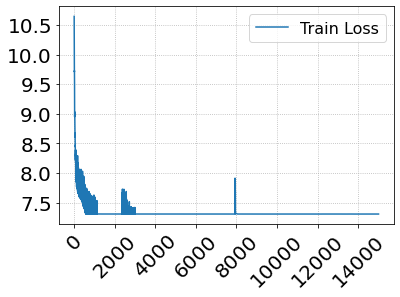

In [5]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, n_epochs+1), np.log10(history), label="Train Loss")
plt.legend(fontsize = 16)
#plt.xlabel('x', fontsize = 20)
#plt.ylabel('u', fontsize = 20)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.savefig('convergence_ADAM_maxx.png', dpi = 300, bbox_inches = "tight")
plt.savefig('converge_.pdf')